### Worst Case Projections:

###### Preliminaries:

In [2]:
from matplotlib import pyplot as plt 
import pandas as pd
import xarray
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
import sys  
sys.path.insert(0, '/home/theo/scripts/')
import new_fwi
from new_fwi import FWICLASS
from new_fwi import FWI_calc
from cordex_fwi_pe import get_cordex_addresses
from itertools import groupby
import os
import warnings
from matplotlib import ticker
import matplotlib as mpl
import copy

In [3]:
def get_summer_inds(in_data):
    # Takes .nc file in
    
    try:
        years  = np.array(pd.to_datetime(np.array(in_data.time)).year)
        months = np.array(pd.to_datetime(np.array(in_data.time)).month)
    except:
        years  = np.vectorize(lambda x: x.year) (np.array(in_data.time))
        months = np.vectorize(lambda x: x.month) (np.array(in_data.time))
    
    yr_inds = np.array([np.where(years == i) for i in range(1981,2081)],dtype=object)
    sum_ind = np.concatenate((np.where(months == 6)[0], np.where(months == 7)[0],
                              np.where(months == 8)[0]),axis = 0)

    indices = np.array([np.intersect1d(yr_inds[i][0],sum_ind) for i in range(100)])
    
    return indices

In [4]:
def get_mask():
    region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
    region_mask = region_data.admin_region
    region_mask = np.nan_to_num(region_mask)
    mask = (region_mask == 0).astype(float)
    mask = -1*(mask - 1)
    mask[mask == 0] = np.nan 
    return mask

In [5]:
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()
tag = ['01','04','05','06','07','08','09','10','11','12','13','15']
mask = get_mask()

<class 'list'>


#### Main Body

In [5]:
# Getting indices of some locations that characterise the geospatial trends
cordex_plot_data = np.load('/home/theo/outdata/2.2.outdata/cordex_plot_data.npy')
ukcp18_plot_data = np.load('/home/theo/outdata/2.2.outdata/ukcp18_plot_data.npy')

print(ukcp18_plot_data.shape)
print(cordex_plot_data.shape)

# Highest Diference in Extremes from CORDEX to UKCP18
cord_max = np.unravel_index(np.argmax(cordex_plot_data[1,4,:,:]),(128,108))
ukcp_max = np.unravel_index(np.argmax(ukcp18_plot_data[1,4,:,:]),(128,108))
max_diff = np.unravel_index(np.argmax(ukcp18_plot_data[1,4,:,:] - cordex_plot_data[1,4,:,:]),(128,108))
ukcp18_plot_data[1,4,:,:] / cordex_plot_data[1,4,:,:]
print(cord_max)
print(ukcp_max)
print(max_diff)
# 

(2, 5, 128, 108)
(2, 5, 128, 108)
(23, 59)
(22, 56)
(22, 56)


<ipython-input-5-d24e38dff82f>:12: RuntimeWarning: divide by zero encountered in true_divide
  ukcp18_plot_data[1,4,:,:] / cordex_plot_data[1,4,:,:]
<ipython-input-5-d24e38dff82f>:12: RuntimeWarning: invalid value encountered in true_divide
  ukcp18_plot_data[1,4,:,:] / cordex_plot_data[1,4,:,:]


In [44]:
# Getting the place names:
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()
rainy_data = xarray.open_dataset(directories[4] + pr_files[4], engine = "netcdf4")
lats = np.array(rainy_data.lat)
lons = np.array(rainy_data.lon)
print(lats.shape)
print(lons.shape)

print(f'\nChilterns:')
print(f'{lats[30,60]},{lons[30,60]}')

print(f'\nSouth Downs:')
print(f'{lats[24,59]},{lons[24,59]}')


print(f'\nAfan Forest:')
print(f'{lats[35,46]},{lons[35,46]}')

<class 'list'>
(128, 108)
(128, 108)

Chilterns:
51.61802424763838,-0.9707645739630273

South Downs:
50.95157836903138,-0.8757072701587028

Afan Forest:
51.73437510995213,-3.5988097179482494


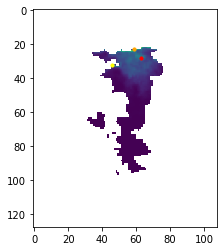

In [81]:
plt.imshow(ukcp18_plot_data[1,3,:,:]*mask)
# Londonish:
# (i.e. the maximum in CORDEX 1980-2000 Very High SR)
plt.scatter(63, 28, s=10, c='red', marker='o')
# West Coast:
# (i.e. the maximum not located on the Isle of Wight)
plt.scatter(59, 23, s=10, c='orange', marker='o')
# Wales:
# (i.e. the maximum north of London)
plt.scatter(46, 32, s=10, c='yellow', marker='o')

In [20]:
# Building CORDEX and UKCP18 data:
fwi_max = np.load('/home/theo/outdata/5.outdata/max_fwi.npy')
# London Area
ldn_max_cord = np.max(fwi_max[:,:,30,60],axis=0)
ldn_avg_cord = np.mean(fwi_max[:,:,30,60],axis=0)
ldn_min_cord = np.min(fwi_max[:,:,30,60],axis=0)
# Dorset: West Coast
dor_max_cord = np.max(fwi_max[:,:,24,59],axis=0)
dor_avg_cord = np.mean(fwi_max[:,:,24,59],axis=0)
dor_min_cord = np.min(fwi_max[:,:,24,59],axis=0)
# Welsh Coast
wls_max_cord = np.max(fwi_max[:,:,35,46],axis=0)
wls_avg_cord = np.mean(fwi_max[:,:,35,46],axis=0)
wls_min_cord = np.min(fwi_max[:,:,35,46],axis=0)

fwi_max_uk = np.load('/home/theo/outdata/5.outdata/max_fwi_ukcp.npy')
# London Area
ldn_max_ukcp = np.max(fwi_max_uk[:,:,30,60],axis=0)
ldn_avg_ukcp = np.mean(fwi_max_uk[:,:,30,60],axis=0)
ldn_min_ukcp = np.min(fwi_max_uk[:,:,30,60],axis=0)
# Dorset: West Coast
dor_max_ukcp = np.max(fwi_max_uk[:,:,24,59],axis=0)
dor_avg_ukcp = np.mean(fwi_max_uk[:,:,24,59],axis=0)
dor_min_ukcp = np.min(fwi_max_uk[:,:,24,59],axis=0)
# Welsh Coast
wls_max_ukcp = np.max(fwi_max_uk[:,:,35,46],axis=0)
wls_avg_ukcp = np.mean(fwi_max_uk[:,:,35,46],axis=0)
wls_min_ukcp = np.min(fwi_max_uk[:,:,35,46],axis=0)

In [88]:
print(ldn_avg_ukcp.shape)

(100,)


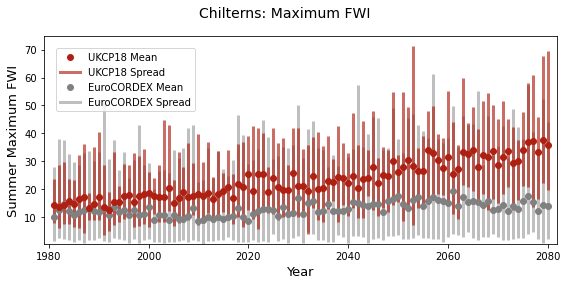

In [21]:
colours =['#0A9396','#94D2BD','#E9D8A6','#EE9B00','#CA6702','#AE2012']
dates = np.array([1981 + i for i in range(100)])

fig,ax = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(8)
fig.suptitle(f'Chilterns: Maximum FWI',fontsize=14)


# Plotting CORDEX:
ax.plot(dates, ldn_avg_cord,'o', color='grey')
ax.errorbar(dates, ldn_avg_cord,
             yerr=np.stack((ldn_avg_cord - ldn_min_cord, ldn_max_cord - ldn_avg_cord)), 
             fmt='', color='grey', ecolor='grey', alpha=0.5,
             elinewidth=3, capsize=0,ls='none')
#ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
#ax.set_ylim(0.9*min(np.min(cordex_data),np.min(ukcp18_data)),1.1*max(np.max(cordex_data),np.max(ukcp18_data)))


# Plotting UKCP18:
ax.plot(dates, ldn_avg_ukcp,'o', color=colours[5])
ax.errorbar(dates, ldn_avg_ukcp,
             yerr=np.stack((ldn_avg_ukcp - ldn_min_ukcp, ldn_max_ukcp - ldn_avg_ukcp)), 
             fmt='', color=colours[5], ecolor=colours[5], alpha=0.65,
             elinewidth=3, capsize=0,ls='none')
handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor=colours[5], markersize=8),
           mpl.lines.Line2D([0], [0], color=colours[5], linewidth=3, linestyle='-',alpha=0.65),
           mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='grey', markersize=8),
           mpl.lines.Line2D([0], [0], color='grey', linewidth=3, linestyle='-',alpha=0.5)]
ax.legend(handles,['UKCP18 Mean','UKCP18 Spread','EuroCORDEX Mean','EuroCORDEX Spread'],
          loc=2,borderaxespad=1.2)
ax.set_xlabel('Year',fontsize=13)
ax.set_ylabel('Summer Maximum FWI',fontsize=13)
ax.margins(x=0.02)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
ax.set_ylim(0.9*min(np.min(ldn_min_cord),np.min(ldn_min_ukcp)),1.05*max(np.max(ldn_max_cord),np.max(ldn_max_ukcp)))
plt.tight_layout()

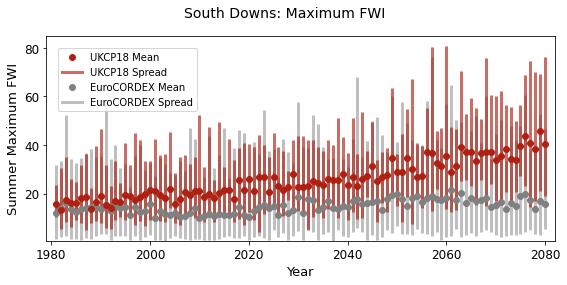

In [9]:
colours =['#0A9396','#94D2BD','#E9D8A6','#EE9B00','#CA6702','#AE2012']
dates = np.array([1981 + i for i in range(100)])

fig,ax = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(8)
fig.suptitle(f'South Downs: Maximum FWI',fontsize=14)


# Plotting CORDEX:
ax.plot(dates, dor_avg_cord,'o', color='grey')
ax.errorbar(dates, dor_avg_cord,
             yerr=np.stack((dor_avg_cord - dor_min_cord, dor_max_cord - dor_avg_cord)), 
             fmt='', color='grey', ecolor='grey', alpha=0.5,
             elinewidth=3, capsize=0,ls='none')
#ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
#ax.set_ylim(0.9*min(np.min(cordex_data),np.min(ukcp18_data)),1.1*max(np.max(cordex_data),np.max(ukcp18_data)))


# Plotting UKCP18:
ax.plot(dates, dor_avg_ukcp,'o', color=colours[5])
ax.errorbar(dates, dor_avg_ukcp,
             yerr=np.stack((dor_avg_ukcp - dor_min_ukcp, dor_max_ukcp - dor_avg_ukcp)), 
             fmt='', color=colours[5], ecolor=colours[5], alpha=0.65,
             elinewidth=3, capsize=0,ls='none')
handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor=colours[5], markersize=8),
           mpl.lines.Line2D([0], [0], color=colours[5], linewidth=3, linestyle='-',alpha=0.65),
           mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='grey', markersize=8),
           mpl.lines.Line2D([0], [0], color='grey', linewidth=3, linestyle='-',alpha=0.5)]
ax.legend(handles,['UKCP18 Mean','UKCP18 Spread','EuroCORDEX Mean','EuroCORDEX Spread'],
          loc=2,borderaxespad=1.2)
ax.set_xlabel('Year',fontsize=13)
ax.set_ylabel('Summer Maximum FWI',fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.margins(x=0.02)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
ax.set_ylim(0.9*min(np.min(dor_min_cord),np.min(dor_min_ukcp)),1.05*max(np.max(dor_max_cord),np.max(dor_max_ukcp)))
plt.tight_layout()

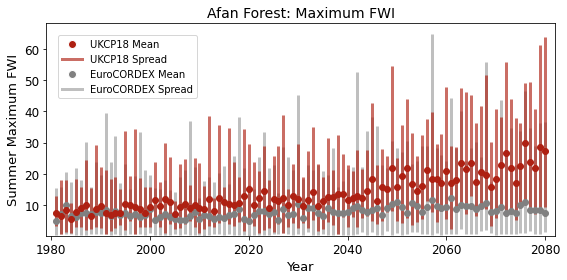

In [14]:
colours =['#0A9396','#94D2BD','#E9D8A6','#EE9B00','#CA6702','#AE2012']
dates = np.array([1981 + i for i in range(100)])

fig,ax = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(8)
ax.set_title(f'Afan Forest: Maximum FWI',fontsize=14)


# Plotting CORDEX:
ax.plot(dates, wls_avg_cord,'o', color='grey')
ax.errorbar(dates, wls_avg_cord,
             yerr=np.stack((wls_avg_cord - wls_min_cord, wls_max_cord - wls_avg_cord)), 
             fmt='', color='grey', ecolor='grey', alpha=0.5,
             elinewidth=3, capsize=0,ls='none')
#ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
#ax.set_ylim(0.9*min(np.min(cordex_data),np.min(ukcp18_data)),1.1*max(np.max(cordex_data),np.max(ukcp18_data)))


# Plotting UKCP18:
ax.plot(dates, wls_avg_ukcp,'o', color=colours[5])
ax.errorbar(dates, wls_avg_ukcp,
             yerr=np.stack((wls_avg_ukcp - wls_min_ukcp, wls_max_ukcp - wls_avg_ukcp)), 
             fmt='', color=colours[5], ecolor=colours[5], alpha=0.65,
             elinewidth=3, capsize=0,ls='none')
handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor=colours[5], markersize=8),
           mpl.lines.Line2D([0], [0], color=colours[5], linewidth=3, linestyle='-',alpha=0.65),
           mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='grey', markersize=8),
           mpl.lines.Line2D([0], [0], color='grey', linewidth=3, linestyle='-',alpha=0.5)]
ax.legend(handles,['UKCP18 Mean','UKCP18 Spread','EuroCORDEX Mean','EuroCORDEX Spread'],
          loc=2,borderaxespad=1.2)
ax.set_xlabel('Year',fontsize=13)
ax.set_ylabel('Summer Maximum FWI',fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.margins(x=0.02)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
ax.set_ylim(0.9*min(np.min(wls_min_cord),np.min(wls_min_ukcp)),1.05*max(np.max(wls_max_cord),np.max(wls_max_ukcp)))
plt.tight_layout()

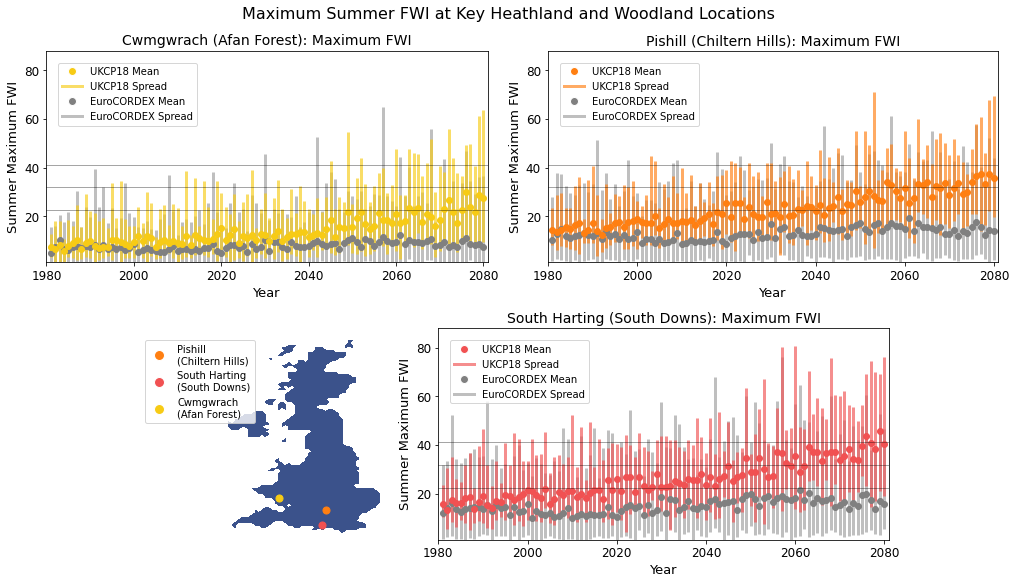

In [42]:
fig = plt.figure(figsize=(14, 8),constrained_layout=True)
widths = [1,1.92,1,3,1]
heights = [1,1]
grid = fig.add_gridspec(ncols=5, nrows=2, width_ratios=widths,height_ratios=heights)

fig.suptitle('Maximum Summer FWI at Key Heathland and Woodland Locations',fontsize = 16)



ax_1 = fig.add_subplot(grid[0,0:3])
ax_1.set_title(f'Cwmgwrach (Afan Forest): Maximum FWI',fontsize=14)
# Plotting CORDEX:
ax_1.plot(dates, wls_avg_cord,'o', color='grey')
ax_1.errorbar(dates, wls_avg_cord,
             yerr=np.stack((wls_avg_cord - wls_min_cord, wls_max_cord - wls_avg_cord)), 
             fmt='', color='grey', ecolor='grey', alpha=0.5,
             elinewidth=3, capsize=0,ls='none')
# Plotting UKCP18:
ax_1.plot(dates, wls_avg_ukcp,'o', color='#F7CB15')
ax_1.errorbar(dates, wls_avg_ukcp,
             yerr=np.stack((wls_avg_ukcp - wls_min_ukcp, wls_max_ukcp - wls_avg_ukcp)), 
             fmt='', color='#F7CB15', ecolor='#F7CB15', alpha=0.65,
             elinewidth=3, capsize=0,ls='none')
handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='#F7CB15', markersize=8),
           mpl.lines.Line2D([0], [0], color='#F7CB15', linewidth=3, linestyle='-',alpha=0.65),
           mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='grey', markersize=8),
           mpl.lines.Line2D([0], [0], color='grey', linewidth=3, linestyle='-',alpha=0.5)]
ax_1.legend(handles,['UKCP18 Mean','UKCP18 Spread','EuroCORDEX Mean','EuroCORDEX Spread'],
          loc=2,borderaxespad=1.2)
ax_1.set_xlabel('Year',fontsize=13)
ax_1.set_ylabel('Summer Maximum FWI',fontsize=13)
ax_1.tick_params(axis='both', which='major', labelsize=12)
ax_1.margins(x=0.02)
ax_1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
ax_1.set_ylim(0.9*min(np.min(wls_min_cord),np.min(wls_min_ukcp)),1.05*max(np.max(wls_max_cord),np.max(wls_max_ukcp)))
ax_1.set_ylim(1,88)
ax_1.set_xlim(1980,2081)



ax_2 = fig.add_subplot(grid[0,3:])
ax_2.set_title(f'Pishill (Chiltern Hills): Maximum FWI',fontsize=14)
# Plotting CORDEX:
ax_2.plot(dates, ldn_avg_cord,'o', color='grey')
ax_2.errorbar(dates, ldn_avg_cord,
             yerr=np.stack((ldn_avg_cord - ldn_min_cord, ldn_max_cord - ldn_avg_cord)), 
             fmt='', color='grey', ecolor='grey', alpha=0.5,
             elinewidth=3, capsize=0,ls='none')
# Plotting UKCP18:
ax_2.plot(dates, ldn_avg_ukcp,'o', color='#FF7F11')
ax_2.errorbar(dates, ldn_avg_ukcp,
             yerr=np.stack((ldn_avg_ukcp - ldn_min_ukcp, ldn_max_ukcp - ldn_avg_ukcp)), 
             fmt='', color='#FF7F11', ecolor='#FF7F11', alpha=0.65,
             elinewidth=3, capsize=0,ls='none')
handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='#FF7F11', markersize=8),
           mpl.lines.Line2D([0], [0], color='#FF7F11', linewidth=3, linestyle='-',alpha=0.65),
           mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='grey', markersize=8),
           mpl.lines.Line2D([0], [0], color='grey', linewidth=3, linestyle='-',alpha=0.5)]
ax_2.legend(handles,['UKCP18 Mean','UKCP18 Spread','EuroCORDEX Mean','EuroCORDEX Spread'],
          loc=2,borderaxespad=1.2)
ax_2.set_xlabel('Year',fontsize=13)
ax_2.set_ylabel('Summer Maximum FWI',fontsize=13)
ax_2.tick_params(axis='both', which='major', labelsize=12)
ax_2.margins(x=0.02)
ax_2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
ax_2.set_ylim(0.9*min(np.min(ldn_min_cord),np.min(ldn_min_ukcp)),1.05*max(np.max(ldn_max_cord),np.max(ldn_max_ukcp)))
ax_2.set_ylim(1,88)
ax_2.set_xlim(1980,2081)


#[18:105,28:80]
ax_3 = fig.add_subplot(grid[1,1:2])
ax_3.contourf(mask[18:105,28:80])
# Chilterns (Pishill):
ax_3.scatter(60-28, 30-18, s=50, c='#FF7F11', marker='o')
# South Downs (South Harting):
ax_3.scatter(59-28, 24-18, s=50, c='#F15152', marker='o')
# Afan Forest (Cwmgwrach):
ax_3.scatter(46-28, 35-18, s=50, c='#F7CB15', marker='o')
handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='#FF7F11', markersize=10),
           mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='#F15152', markersize=10),
           mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='#F7CB15', markersize=10)]
ax_3.legend(handles,['Pishill\n(Chiltern Hills)','South Harting\n(South Downs)','Cwmgwrach\n(Afan Forest)'],
            loc=2,borderaxespad=1.2,bbox_to_anchor=(-0.5, 1))
ax_3.axis('off')


ax_4 = fig.add_subplot(grid[1,2:4])
ax_4.set_title(f'South Harting (South Downs): Maximum FWI',fontsize=14)
# Plotting CORDEX:
ax_4.plot(dates, dor_avg_cord,'o', color='grey')
ax_4.errorbar(dates, dor_avg_cord,
             yerr=np.stack((dor_avg_cord - dor_min_cord, dor_max_cord - dor_avg_cord)), 
             fmt='', color='grey', ecolor='grey', alpha=0.5,
             elinewidth=3, capsize=0,ls='none')
# Plotting UKCP18:
ax_4.plot(dates, dor_avg_ukcp,'o', color='#F15152')
ax_4.errorbar(dates, dor_avg_ukcp,
             yerr=np.stack((dor_avg_ukcp - dor_min_ukcp, dor_max_ukcp - dor_avg_ukcp)), 
             fmt='', color='#F15152', ecolor='#F15152', alpha=0.65,
             elinewidth=3, capsize=0,ls='none')
handles = [mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='#F15152', markersize=8),
           mpl.lines.Line2D([0], [0], color='#F15152', linewidth=3, linestyle='-',alpha=0.65),
           mpl.lines.Line2D([0], [0], marker='o', color='w',markerfacecolor='grey', markersize=8),
           mpl.lines.Line2D([0], [0], color='grey', linewidth=3, linestyle='-',alpha=0.5)]
ax_4.legend(handles,['UKCP18 Mean','UKCP18 Spread','EuroCORDEX Mean','EuroCORDEX Spread'],
          loc=2,borderaxespad=1.2)
ax_4.set_xlabel('Year',fontsize=13)
ax_4.set_ylabel('Summer Maximum FWI',fontsize=13)
ax_4.tick_params(axis='both', which='major', labelsize=12)
ax_4.margins(x=0.02)
ax_4.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}"))
ax_4.set_ylim(1,88)
ax_4.set_xlim(1980,2081)
ax_4.axhline(y=41.2, color='k', linestyle='-',linewidth = 0.5,alpha=0.7)
ax_4.axhline(y=31.9, color='k', linestyle='-',linewidth = 0.5,alpha=0.7)
ax_4.axhline(y=22.4, color='k', linestyle='-',linewidth = 0.5,alpha=0.7)

ax_1.axhline(y=41.2, color='k', linestyle='-',linewidth = 0.5,alpha=0.7)
ax_1.axhline(y=31.9, color='k', linestyle='-',linewidth = 0.5,alpha=0.7)
ax_1.axhline(y=22.4, color='k', linestyle='-',linewidth = 0.5,alpha=0.7)

ax_2.axhline(y=41.2, color='k', linestyle='-',linewidth = 0.5,alpha=0.7)
ax_2.axhline(y=31.9, color='k', linestyle='-',linewidth = 0.5,alpha=0.7)
ax_2.axhline(y=22.4, color='k', linestyle='-',linewidth = 0.5,alpha=0.7)

plt.savefig('/home/theo/final_images/7.images/characteristic_locations')

#### Severity Occurance Plots

In [13]:
yrs_36525 = np.array([365, 365, 365, 366]*25)
yrs_36000 = np.array([360, 360, 360, 360]*25)

36525


In [ ]:
# Getting Data:
# Pishill:
    # CORDEX
for i in range(48):
    fwi_cord = np.load(f'/data/met/fwi/ukcordex_new_fwi_{i+1}.npy')
    fwi_cord_pish = fwi_cord[0,:,30,60]
    fwi_cord_hart = fwi_cord[0,:,24,59]
    fwi_cord_afan = fwi_cord[0,:,35,46]
    print(fwi_total.shape)
    del fwi_cord
    # UKCP


(36525,)
(36525,)
(36525,)
(36525,)
(36525,)
(36525,)
(36525,)


In [8]:
fwi_ukcp = np.load('/home/theo/outdata/2.1.outdata/ukcp18_regional_fwi_severity_by_area.npy')[:,:,0,:]
fwi_ukcordex = np.load('/home/theo/outdata/2.1.outdata/ukcordex_regional_fwi_severity_by_area.npy')[:,1:,0,:]

print(fwi_ukcordex.shape)

(6, 48, 100)


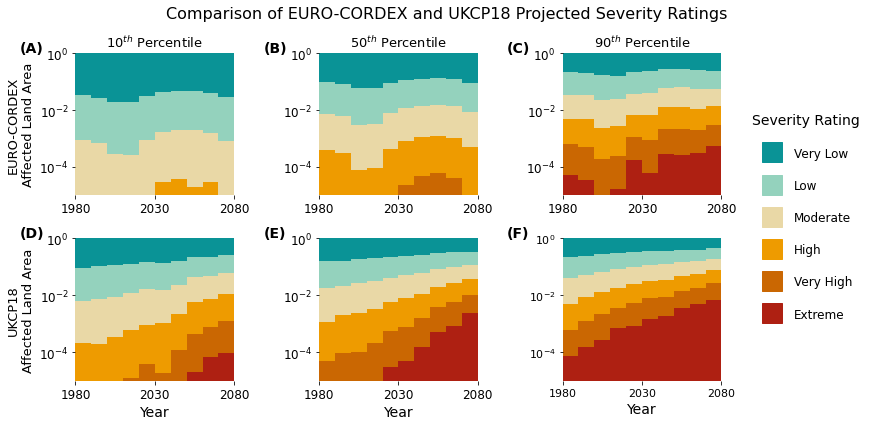

In [7]:
fwi_ukcp = np.load('/home/theo/outdata/2.1.outdata/ukcp18_regional_fwi_severity_by_area.npy')[:,:,0,:]
fwi_ukcordex = np.load('/home/theo/outdata/2.1.outdata/ukcordex_regional_fwi_severity_by_area.npy')[:,1:,0,:]
colours = ['#0A9396','#94D2BD','#E9D8A6','#EE9B00','#CA6702','#AE2012']
markers = 6*['s']
numbers = [0,90,99,99.9,99.99,99.999,100]
labels = [f'{numbers[i]} to {numbers[i+1]}%' for i in range(6)]
labels = ['Very Low','Low','Moderate','High','Very High','Extreme']
#['0-90','90-99','99-99.9','99.9-99.99','99.99-99.999','99.999-100']
handles = 6*[]


fig = plt.figure(figsize=(12.5, 6),tight_layout=True)
fig.suptitle('Comparison of EURO-CORDEX and UKCP18 Projected Severity Ratings',fontsize = 16)
widths = [1,1,1,0.5]
heights = [1, 1]
grid = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths,height_ratios=heights)


ax_1 = fig.add_subplot(grid[0,0])
ax_1.set_title('Pishill (Chiltern Hills)',fontsize=13)
ax_1.set_ylabel('EURO-CORDEX\nAffected Land Area',fontsize=13)
bottom = 10 * [0]
fwi_inputs = np.percentile(fwi_ukcordex,10,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
fwi_by_dec = np.empty((6,10))
for j in range(10):
    fwi_by_dec[:,j] = np.mean(fwi_inputs[:,j*10:(j+1)*10],axis=1)
for i in range(5,-1,-1):
    ax_1.bar(1985+np.arange(10)*10,fwi_by_dec[i,:], bottom=bottom, width = 10.0, color=colours[i])
    bottom = bottom + fwi_by_dec[i,:]
ax_1.set_yscale('log') 
ax_1.set_ylim([0.00001,1])
ax_1.spines['right'].set_visible(False)
ax_1.spines['left'].set_visible(False)
ax_1.spines['top'].set_visible(False)
ax_1.spines['bottom'].set_visible(False)
ax_1.tick_params(labelsize=12)
ax_1.yaxis.set_ticks([10**-4,10**-2,10**-0])
ax_1.xaxis.set_ticks([1980,2030,2080])
ax_1.set_xlim((1980, 2080)) 
ax_1.text(1945,1.1, '(A)', size=14,weight='bold')


ax_2 = fig.add_subplot(grid[1,0])
ax_2.set_ylabel('UKCP18\nAffected Land Area',fontsize=13)
bottom = 10 * [0]
fwi_inputs = np.percentile(fwi_ukcp,10,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
fwi_by_dec = np.empty((6,10))
for j in range(10):
    fwi_by_dec[:,j] = np.mean(fwi_inputs[:,j*10:(j+1)*10],axis=1)
for i in range(5,-1,-1):
    ax_2.bar(1985+np.arange(10)*10,fwi_by_dec[i,:], bottom=bottom, width = 10.0, color=colours[i])
    bottom = bottom + fwi_by_dec[i,:]
ax_2.set_xlabel('Year', fontsize = 14)
ax_2.set_yscale('log') 
ax_2.set_ylim([0.00001,1])
ax_2.spines['right'].set_visible(False)
ax_2.spines['left'].set_visible(False)
ax_2.spines['top'].set_visible(False)
ax_2.spines['bottom'].set_visible(False)
ax_2.tick_params(labelsize=12)
ax_2.yaxis.set_ticks([10**-4,10**-2,10**-0])
ax_2.xaxis.set_ticks([1980,2030,2080])
ax_2.set_xlim((1980, 2080)) 
ax_2.text(1945,1.1, '(D)', size=14,weight='bold')


ax_3 = fig.add_subplot(grid[0,1])
ax_3.set_title('50$^{th}$ Percentile',fontsize=13)
bottom = 10 * [0]
fwi_inputs = np.percentile(fwi_ukcordex,50,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
fwi_by_dec = np.empty((6,10))
for j in range(10):
    fwi_by_dec[:,j] = np.mean(fwi_inputs[:,j*10:(j+1)*10],axis=1)
for i in range(5,-1,-1):
    ax_3.bar(1985+np.arange(10)*10,fwi_by_dec[i,:], bottom=bottom, width = 10.0, color=colours[i])
    bottom = bottom + fwi_by_dec[i,:]
ax_3.set_yscale('log') 
ax_3.set_ylim([0.00001,1])
ax_3.spines['right'].set_visible(False)
ax_3.spines['left'].set_visible(False)
ax_3.spines['top'].set_visible(False)
ax_3.spines['bottom'].set_visible(False)
ax_3.tick_params(labelsize=12)
ax_3.yaxis.set_ticks([10**-4,10**-2,10**-0])
ax_3.xaxis.set_ticks([1980,2030,2080])
ax_3.set_xlim((1980, 2080)) 
ax_3.text(1945,1.1, '(B)', size=14,weight='bold')


ax_4 = fig.add_subplot(grid[1,1])
bottom = 10 * [0]
fwi_inputs = np.percentile(fwi_ukcp,50,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
fwi_by_dec = np.empty((6,10))
for j in range(10):
    fwi_by_dec[:,j] = np.mean(fwi_inputs[:,j*10:(j+1)*10],axis=1)
for i in range(5,-1,-1):
    ax_4.bar(1985+np.arange(10)*10,fwi_by_dec[i,:], bottom=bottom, width = 10.0, color=colours[i])
    bottom = bottom + fwi_by_dec[i,:]
ax_4.set_xlabel('Year', fontsize = 14)
ax_4.set_yscale('log') 
ax_4.set_ylim([0.00001,1])
ax_4.spines['right'].set_visible(False)
ax_4.spines['left'].set_visible(False)
ax_4.spines['top'].set_visible(False)
ax_4.spines['bottom'].set_visible(False)
ax_4.tick_params(labelsize=12)
ax_4.yaxis.set_ticks([10**-4,10**-2,10**-0])
ax_4.xaxis.set_ticks([1980,2030,2080])
ax_4.set_xlim((1980, 2080)) 
ax_4.text(1945,1.1, '(E)', size=14,weight='bold')


ax_5 = fig.add_subplot(grid[0,2])
ax_5.set_title('90$^{th}$ Percentile',fontsize=13)
bottom = 10 * [0]
fwi_inputs = np.percentile(fwi_ukcordex,90,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
fwi_by_dec = np.empty((6,10))
for j in range(10):
    fwi_by_dec[:,j] = np.mean(fwi_inputs[:,j*10:(j+1)*10],axis=1)
for i in range(5,-1,-1):
    ax_5.bar(1985+np.arange(10)*10,fwi_by_dec[i,:], bottom=bottom, width = 10.0, color=colours[i])
    bottom = bottom + fwi_by_dec[i,:]
ax_5.set_yscale('log') 
ax_5.set_ylim([0.00001,1])
ax_5.spines['right'].set_visible(False)
ax_5.spines['left'].set_visible(False)
ax_5.spines['top'].set_visible(False)
ax_5.spines['bottom'].set_visible(False)
ax_5.tick_params(labelsize=12)
ax_5.yaxis.set_ticks([10**-4,10**-2,10**-0])
ax_5.xaxis.set_ticks([1980,2030,2080])
ax_5.set_xlim((1980, 2080)) 
ax_5.text(1945,1.1, '(C)', size=14,weight='bold')

ax_6 = fig.add_subplot(grid[1,2])
bottom = 10 * [0]
fwi_inputs = np.percentile(fwi_ukcp,90,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
fwi_by_dec = np.empty((6,10))
for j in range(10):
    fwi_by_dec[:,j] = np.mean(fwi_inputs[:,j*10:(j+1)*10],axis=1)
for i in range(5,-1,-1):
    ax_6.bar(1985+np.arange(10)*10,fwi_by_dec[i,:], bottom=bottom, width = 10.0, color=colours[i])
    bottom = bottom + fwi_by_dec[i,:]
ax_6.set_xlabel('Year', fontsize = 14)
ax_6.set_yscale('log') 
ax_6.set_ylim([0.00001,1])
ax_6.spines['right'].set_visible(False)
ax_6.spines['left'].set_visible(False)
ax_6.spines['top'].set_visible(False)
ax_6.spines['bottom'].set_visible(False)
ax_6.tick_params(labelsize=11)
ax_6.yaxis.set_ticks([10**-4,10**-2,10**-0])
ax_6.xaxis.set_ticks([1980,2030,2080])
ax_6.set_xlim((1980, 2080)) 
ax_6.text(1945,1.1, '(F)', size=14,weight='bold')

ax_7 = fig.add_subplot(grid[:,3])
handles = [mpl.lines.Line2D([], [], color=colours[i], marker='s', 
                            linestyle='None',markersize=10, 
                            label=labels[i]) for i in range(6)]
ax_7.legend(handles=handles,bbox_to_anchor=(0.0, 0.5),markerscale=2,
           title = 'Severity Rating', title_fontsize = 14,
           frameon = False, fontsize=12, loc='center',
           labelspacing=1.6)
ax_7.axis('off')


plt.tight_layout()
plt.savefig('/home/theo/final_images/7.images/case_study_severity_occurance')